<a href="https://colab.research.google.com/github/evan-placenis/Transformer-Text-Summarization/blob/main/Transformer_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation

In [5]:
pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.1 MB/s eta 0:00:00


In [6]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.2 MB/s eta 0:00:00


In [7]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00


In [8]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=491a4e5631a2d433827c57b4b7db58e50bb913c83b04a8cfb3580e2e2640b3b8
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [9]:
pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.8 MB/s eta 0:00:00


In [10]:
pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.9 MB/s eta 0:00:00


##### Evalution Function

In [6]:
from tqdm import tqdm
import torch
def chunks(list_of_elements, batch_size):
  #yeild batch-sized chunks from list_of_elements
  for i in range(0, len(list_of_elements), batch_size):
    yield list_of_elements[i : i + 1]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size = 16,
                               column_text = "article",
                               column_summary = "highlights"):
  article_batches = list(chunks(dataset[column_text], batch_size))
  target_batches = list(chunks(dataset[column_summary], batch_size))

  for article_batch, target_batch in tqdm(
      zip(article_batches, target_batches), total = len(article_batches)):
      inputs = tokenizer(article_batch, max_length = 1024, truncation = True,
                         padding=  "max_length", return_tensors = "pt")

      summaries = model.generate(input_ids = inputs["input_ids"],
                                 attention_mask = inputs["attention_mask"],
                                 length_penalty = 0.8, num_beams = 8, max_length = 128)
      for s in summaries:

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens = True,
                                              clean_up_tokenization_spaces = True)]

      decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]

      metric.add_batch(predictions = decoded_summaries, references = target_batch)

  score = metric.compute()
  return score

##Loading CNN/DailyMail Dataset

In [25]:
 from datasets import load_dataset
 dataset = load_dataset("cnn_dailymail", version = "3.0.0")
 print(f"Features: {dataset['train'].column_names}")

Features: ['article', 'highlights', 'id']


In [26]:
sample = dataset["train"][1]
print(f"First 500 characters of article of total length: {len(sample['article'])}")
print(sample["article"][:500])
print(f"\nSummary length: {len(sample['highlights'])}")
print(sample["highlights"])

First 500 characters of article of total length: 4051
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary length: 281
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


In [28]:
import nltk
from nltk.tokenize import sent_tokenize #sophisticated algorithm to differentiate end of sentence and punctuation from abbreviations
nltk.download("punkt")

def three_sentence_summary(text):
  return "/n".join(sent_tokenize(text)[:3])

summaries = {}
sample_text = dataset["train"][1]["article"][:2000]

summaries["baseline"] = three_sentence_summary(sample_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Bart Summary

In [29]:
from transformers import pipeline, set_seed
set_seed(42)
pipe = pipeline("summarization", model = "facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

## Pegasus Summary

In [30]:
# pipe = pipeline("summarization", model = "google/pegasus-xsum")
# pipe_out = pipe(sample_text)
# summaries["pegasus"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .", ".\n")

## Observe Models Summaries

In [31]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")
for model_name in summaries:
  print(model_name.upper())
  print(summaries[model_name])
  print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events./nHere, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial./nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

BART
Mentally ill inmates are housed on the "forgotten floor" of Miami-Dade jail.
Most often, they face drug charges or charges of assaulting an officer.
Judge Steven Leifman says the arrests often result from confrontati

####Evaluate Pegasus model with Rouge score (developed for summarization applications)

In [13]:
from datasets import load_metric
rouge_metric = load_metric("rouge")

test_sampled = dataset["test"].shuffle(seed = 42).select(range(1000))

<ipython-input-13-ba0d1893de7e>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_pt = "google/pegasus-xsum"
tokenizer = AutoTokenizer.from_pretrained(model_pt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_pt)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, model, tokenizer, batch_size = 8)
print(score)

## Training Custom Summarization Model on Samsung Dialog Dataset (Fine Tune Pegasus)

In [1]:
from datasets import load_dataset
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split length: {split_lengths}")
print(f"Features : {dataset_samsum['train'].column_names}")
print("\n Dialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary")
print(dataset_samsum["test"][0]["summary"])

Split length: [14732, 819, 818]
Features : ['id', 'dialogue', 'summary']

 Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [7]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary")
print("\n".join(sent_tokenize(pipe_out[0]["summary_text"])))


Summary
Amanda: Hey Hannah, do you have Betty's number?


In [2]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


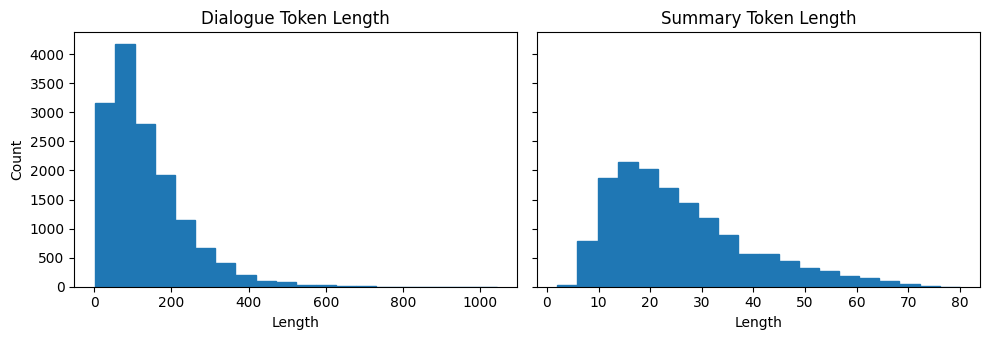

In [3]:
import matplotlib.pyplot as plt

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1,2, figsize = (10, 3.5), sharey = True)
axes[0].hist(d_len, bins = 20, color = "C0", edgecolor = "C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins = 20, color = "C0", edgecolor = "C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [4]:
#tokenize the dataset so it can be trained
def convert_examples_to_features(example_batch):
  input_encodings = tokenizer(example_batch["dialogue"], max_length = 1024, truncation = True)

  #.as_target_tokenizer --> tokenization for the decoder
  with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(example_batch["summary"], max_length = 128, truncation = True)

  return {"input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched = True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type = "torch", columns = columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [5]:
from transformers import DataCollatorForSeq2Seq
#shifting labels to the right by one and ignore padding tokens
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)

In [6]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'pegasus-samsum', num_train_epochs = 1,
    warmup_steps = 500, per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,weight_decay = 0.01,
    logging_steps = 10, push_to_hub = True, evaluation_strategy = "steps",
    eval_steps = 500, save_steps = 1e6, gradient_accumulation_steps = 16)

In [7]:
from huggingface_hub import notebook_login
notebook_login()

In [9]:

trainer = Trainer(model = model, args = training_args, tokenizer = tokenizer,
                  data_collator = seq2seq_data_collator,
                  train_dataset = dataset_samsum_pt["train"],
                  eval_dataset = dataset_samsum_pt["validation"])

In [10]:
trainer.train()
trainer.push_to_hub("Training Complete")

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.631500,1.488017


pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

'https://huggingface.co/Evan-Placenis/pegasus-samsum/tree/main/'

###Generating  Dialogue Summaries

In [19]:
from transformers import pipeline
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model = "Evan-Placenis/pegasus-samsum")

In [20]:
print("Dialogue:")
print(sample_text)
print("\nReference Summary")
print(reference)
print("\n Model Summary")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

 Model Summary
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


###Generating off of custom dialog

In [23]:
custom_dialog = """\
Evan: Hi guys, have you heard of transformers?
Lukas: Yer, I used them recently!
Cole: Indeed, ther is a great library by Hugging Face
Evan: I know, I used it today.
Lukas: Cool, we should use it together and make an app!
Cole: Great Idea!
Evan: Awsome, lets do it.
"""

print(pipe(custom_dialog, **gen_kwargs)[0]["summary_text"])

Lukas, Cole and Evan are going to make an app using the transformers library by Hugging Face. Lukas, Cole and Evan are going to use it together.
